# Problem 1: Image Compression
### 1(a)

In [4]:
import numpy as np
from PIL import Image
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import pandas as pd

(563, 1000)


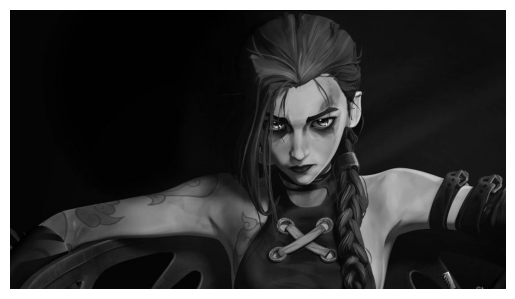

In [2]:
pic = Image.open('jinx.png')

M = np.array(pic, dtype=float)
print(M.shape)

# Display the image
plt.imshow(pic, cmap='gray')
plt.axis('off')
plt.show()

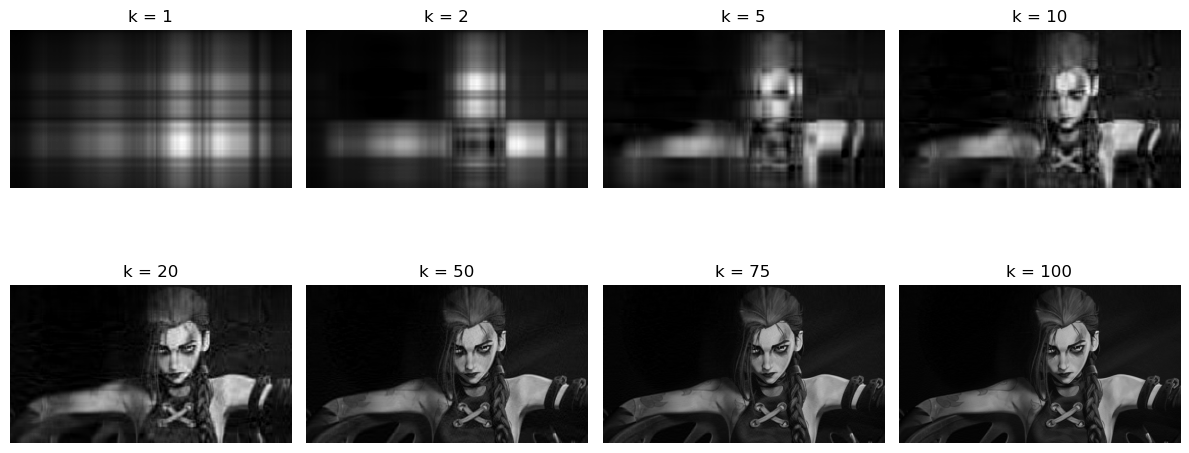

In [3]:
ks = [1, 2, 5, 10, 20, 50, 75, 100]


fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, k in enumerate(ks):
    U, S, Vt = svds(M, k=k)
    M_compressed = np.clip(U @ np.diag(S) @ Vt, 0, 255)  # Clip values to valid range

    ax = axes[i // 4, i % 4]  # Determine row and column index
    ax.imshow(M_compressed, cmap="gray")
    ax.set_title(f"k = {k}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### 1 (c)

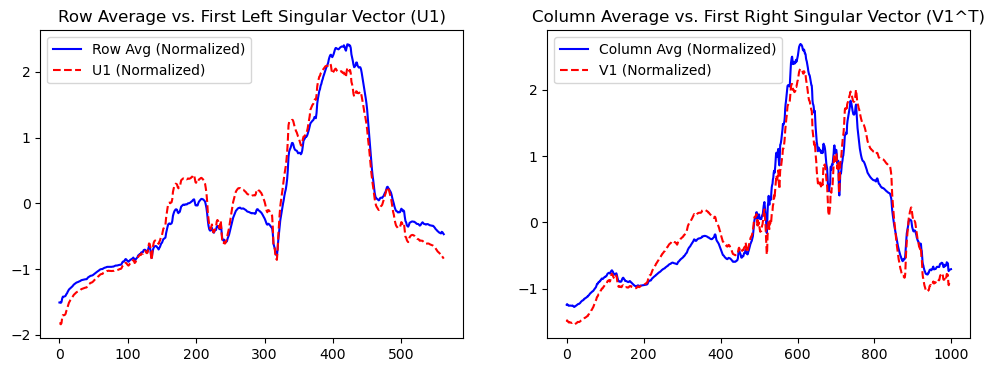

In [32]:
# Compute the rank-1 SVD approximation
U, S, Vt = svds(M, k=1)

# Extract the first left and right singular vectors
U1 = U[:, 0]  # First column of U
V1 = Vt[0, :]  # First row of Vt (V1^T)

# Compute row-wise and column-wise average brightness
row_avg = M.mean(axis=1)
col_avg = M.mean(axis=0)

# Normalize all vectors to have mean 0 and standard deviation 1 for better comparison
U1_normalized = -(U1 - U1.mean()) / U1.std()
V1_normalized = -(V1 - V1.mean()) / V1.std()
row_avg_normalized = (row_avg - row_avg.mean()) / row_avg.std()
col_avg_normalized = (col_avg - col_avg.mean()) / col_avg.std()

# Plot the comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(row_avg_normalized, label="Row Avg (Normalized)", color="blue")
axes[0].plot(U1_normalized, label="U1 (Normalized)", linestyle="dashed", color="red")
axes[0].set_title("Row Average vs. First Left Singular Vector (U1)")
axes[0].legend()

axes[1].plot(col_avg_normalized, label="Column Avg (Normalized)", color="blue")
axes[1].plot(V1_normalized, label="V1 (Normalized)", linestyle="dashed", color="red")
axes[1].set_title("Column Average vs. First Right Singular Vector (V1^T)")
axes[1].legend()

plt.show()


After swapping the sign of U1 and V1, this is about as clear as humanly possible. The right singular vector is almost the column average (going across rows), while the left singular vector is the row average. This is what I expected.

### 1 (d)
For a rank-k approximation, if $M \in \mathbb R^{m \times n}$, $$M = \sum_{i=1}^k \sigma_i u_i v_i^T,$$ where $u_i \in \mathbb R^m$ and $v_i \in \mathbb R^n$. Thus, we have to store $k(m+n+1)$ numbers. In our case, $m = 563$ and $n = 1000$, so we are storing $1564k$ numbers. From the above pictures, the $k = 50$ approximation and the real image are basically indistinguishable. The real image has $563 \times 1000$ numbers stored, vs $50 \cdot 1564$. That's a 7x savings!

### 1 (e)
The main artifact I see is a lot of blurring, for small values of $k$. This happens since we have to recover the image with a lot less precision. From our work before, we found that the $k = 1$ approximation was just taking column/row averages (with small variance). I would then suspect that the later $k$ values are also more specific kinds of averages. Since blurring and averages are the same thing for images, this is why we get blurring.

# Problem 2: Word Embeddings

### 2 (a)


In [5]:
co_occur = pd.read_csv("co_occur.csv.gz", compression="gzip", header=None)
with open('dictionary.txt', 'r') as f:
    dictionary = f.read().splitlines()

In [6]:
M = co_occur.to_numpy(dtype=np.float32)
print(dictionary[:10])
print(M[:5, :5])

['the', 'of', 'in', 'and', 'to', 'was', 'is', 'for', 'on', 'as']
[[       0. 24637000. 13531000.  6871500.  7348100.]
 [24637000.        0.  1388900.  2305900.   495270.]
 [13531000.  1388900.        0.  2761000.  1095500.]
 [ 6871500.  2305900.  2761000.        0.  1272200.]
 [ 7348100.   495270.  1095500.  1272200.        0.]]


In [7]:
M_hat = np.log(1+M)
U, S, Vt = svds(M_hat, k=100)
U = U[:, ::-1]
S = S[::-1]
Vt = Vt[::-1, :]
print(S)

[14299.743    2864.8157   2682.654    1745.5542   1528.4167   1308.7625
  1185.7406   1128.0525   1102.5571    956.3077    916.05383   853.35297
   820.34485   773.66034   719.69446   701.52167   678.18396   642.6447
   617.53845   594.8361    572.23645   567.50305   545.8246    522.75104
   516.8387    512.2936    495.28323   494.94687   489.8868    469.73337
   466.14462   458.85513   447.35144   436.48828   432.12195   429.74777
   419.78088   418.40512   413.4417    407.86383   399.3096    399.13727
   395.82843   383.5555    376.8846    372.25964   372.16504   366.65634
   355.53806   355.15262   350.95648   343.94815   343.17477   336.30023
   330.32028   326.8567    324.25357   322.6871    319.2961    317.67395
   313.0984    311.19812   302.3449    297.87207   293.03714   292.04407
   290.90353   285.9029    283.54883   282.94962   282.10803   277.576
   273.01404   272.3182    269.0307    266.40988   266.16565   263.60944
   262.39072   259.98364   259.25305   257.3319    256.

The first singular value is huge compared to the second, but then there is gradual decay, and no huge jump towards 0. I would say that M does not seem to be low-rank.

### 2 (b)

In [8]:
for i in range(20):
    top_10_indices = np.argsort(np.abs(Vt[i]))[-10:][::-1]
    print(f'#{i+1} singular vector most influential words: ')
    print([dictionary[x] for x in top_10_indices])

#1 singular vector most influential words: 
['the', 'and', 'of', 'in', 'to', 'for', 'as', 'is', 'with', 'was']
#2 singular vector most influential words: 
['the', 'and', 'of', 'in', 'to', 'for', 'with', 'as', 'by', 'is']
#3 singular vector most influential words: 
['born', 'john', 'james', 'david', 'robert', 'william', 'jr', 'george', 'thomas', 'michael']
#4 singular vector most influential words: 
['district', 'you', 'county', 'album', 'council', 'love', 'university', 'me', 'national', 'my']
#5 singular vector most influential words: 
['political', 'jpg', 'km', 'located', 'social', 'near', 'road', 'river', 'religious', 'lake']
#6 singular vector most influential words: 
['troops', 'digital', 'science', 'software', 'technology', 'engineering', 'him', 'computer', 'research', 'online']
#7 singular vector most influential words: 
['ancient', 'medieval', 'century', 'greek', 'culture', 'latin', 'poetry', 'literature', 'folk', 'contemporary']
#8 singular vector most influential words: 
['too

### 2 (c)

In [9]:
U_normalized = U / np.linalg.norm(U, axis=1, keepdims=True)
print(U_normalized.shape)

(10000, 100)


In [10]:
u1 = U_normalized[dictionary.index('woman')]
u2 = U_normalized[dictionary.index('man')]

u = u1 - u2

In [11]:
def plot_proj_vals(words):
    proj_vals = []
    for word in words:
        word_embedding = U_normalized[dictionary.index(word)]
        proj_vals.append(word_embedding @ u)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(words, proj_vals, color="blue")
    plt.xlabel("Words")
    plt.ylabel("Projection Value")
    plt.title("Word Embedding Projections")
    plt.xticks(rotation=45)  # Rotate for better readability
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

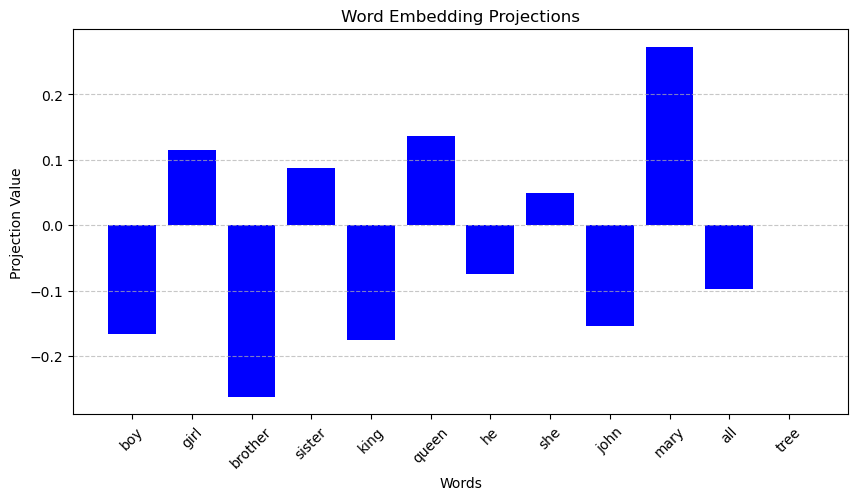

In [12]:
plot_proj_vals(['boy', 'girl', 'brother', 'sister', 'king', 'queen', 'he', 'she', 'john', 'mary', 'all', 'tree'])

### 2 (d)

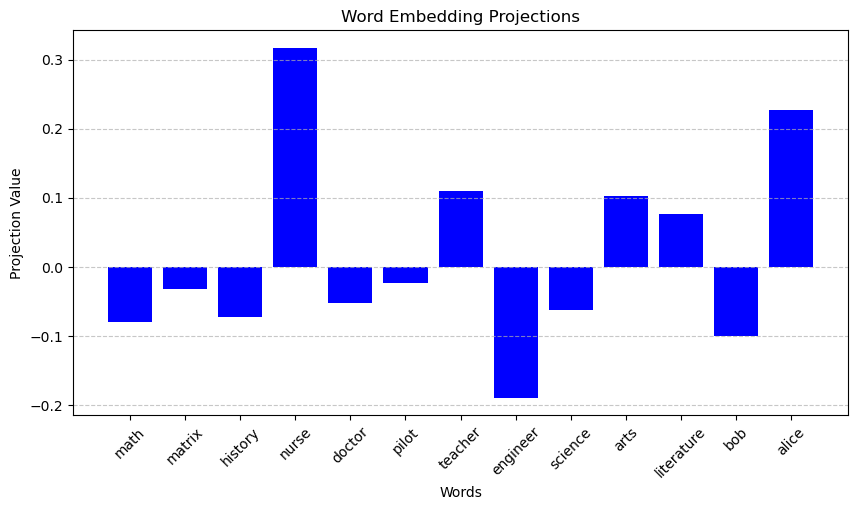

In [13]:
plot_proj_vals(["math", "matrix", "history", "nurse", "doctor", "pilot",
         "teacher", "engineer", "science", "arts", "literature", "bob", "alice"])

### 2 (e)

In [43]:
def most_similar_word_to(word, k):
    index = dictionary.index(word)
    embedding = U_normalized[index]
    similarities = U_normalized @ embedding
    similarities[index] = -np.inf
    most_similar_index = np.argsort(similarities)[-k:]
    return [dictionary[i] for i in most_similar_index][::-1]

In [41]:
print(most_similar_word_to('washington', 10))

['boston', 'chicago', 'york', 'houston', 'philadelphia', 'baltimore', 'kansas', 'texas', 'florida', 'michigan']


In [50]:
def find_analogy_word(a1, a2, b1):
        a1_idx, a2_idx, b1_idx = map(dictionary.index, [a1, a2, b1])
        a1_emb, a2_emb, b1_emb = U_normalized[a1_idx], U_normalized[a2_idx], U_normalized[b1_idx]
        b2_emb = b1_emb + a2_emb - a1_emb
        sims = U_normalized @ b2_emb
        sims[[a1_idx, a2_idx, b1_idx]] = -np.inf # don't want it to give back b1
        b2_idx = np.argmax(sims)

        return dictionary[b2_idx]

In [51]:
print(find_analogy_word('man', 'woman', 'king'))

queen


In [52]:
anal_ds = np.loadtxt('analogy_task.txt', dtype=str)
anal_ds[:5]

array([['athens', 'greece', 'bangkok', 'thailand'],
       ['athens', 'greece', 'beijing', 'china'],
       ['athens', 'greece', 'berlin', 'germany'],
       ['athens', 'greece', 'cairo', 'egypt'],
       ['athens', 'greece', 'canberra', 'australia']], dtype='<U14')

In [53]:
acc = 0.
for i in range(len(anal_ds)):
    analogy = find_analogy_word(anal_ds[i, 0], anal_ds[i, 1], anal_ds[i, 2])
    acc += (analogy == anal_ds[i, 3])
    if analogy != anal_ds[i, 3]:
        print(f'#{i+1} {anal_ds[i, 0]}:{anal_ds[i, 1]}::{anal_ds[i, 2]}:{anal_ds[i, 3]} got {analogy}')
print('accuracy: ', acc/len(anal_ds))

#2 athens:greece::beijing:china got korea
#4 athens:greece::cairo:egypt got morocco
#5 athens:greece::canberra:australia got iceland
#6 athens:greece::helsinki:finland got iceland
#7 athens:greece::london:england got ireland
#8 athens:greece::madrid:spain got argentina
#10 athens:greece::oslo:norway got iceland
#11 athens:greece::ottawa:canada got saskatchewan
#14 athens:greece::stockholm:sweden got norway
#16 bangkok:thailand::beijing:china got korea
#22 bangkok:thailand::madrid:spain got argentina
#24 bangkok:thailand::oslo:norway got iceland
#25 bangkok:thailand::ottawa:canada got manitoba
#28 bangkok:thailand::stockholm:sweden got norway
#34 beijing:china::helsinki:finland got russia
#35 beijing:china::london:england got britain
#36 beijing:china::madrid:spain got argentina
#38 beijing:china::oslo:norway got russia
#42 beijing:china::stockholm:sweden got norway
#46 berlin:germany::cairo:egypt got morocco
#49 berlin:germany::london:england got britain
#52 berlin:germany::oslo:norway

In [59]:
slower_idx, fast_idx, faster_idx, simple_idx, simpler_idx = map(dictionary.index, ['slower', 'fast', 'faster', 'simple', 'simpler'])
slower_emb, fast_emb, faster_emb, simple_emb, simpler_emb = U_normalized[slower_idx], U_normalized[fast_idx], U_normalized[faster_idx], U_normalized[simple_idx], U_normalized[simpler_idx]
print((simpler_emb - simple_emb + fast_emb) @ (faster_emb - slower_emb))

-0.042805213
